In [1]:
!pip install qiskit
!pip install qiskit_aer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
def oracle_constant(qc, ancilla, value=0):
    """Constant oracle: f(x)=0 or f(x)=1"""
    if value == 1:
        qc.x(ancilla)


def oracle_balanced_parity(qc, inputs, ancilla):
    """Balanced oracle: f(x) = x0 XOR x1 XOR ... XOR xn"""
    for q in inputs:
        qc.cx(q, ancilla)
def deutsch_jozsa_circuit(n, oracle_func, *oracle_args):
    """
    n: number of input qubits
    oracle_func: oracle function to modify the circuit
    oracle_args: extra arguments for oracle
    """
    qreg = QuantumRegister(n + 1, "q")
    creg = ClassicalRegister(n, "c")
    qc = QuantumCircuit(qreg, creg)

    inputs = list(range(n))
    ancilla = n

    # Step 1: Initialize |0...0>|1>
    qc.x(ancilla)

    # Step 2: Apply Hadamard to all qubits
    qc.h(qreg)

    # Step 3: Oracle
    oracle_func(qc, *oracle_args)

    # Step 4: Apply Hadamard to input qubits
    for q in inputs:
        qc.h(q)

    # Step 5: Measure only input qubits
    qc.measure(inputs, creg)

    return qc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 99.7 MB/s eta 0:00:00


In [2]:
# ---------- EXECUTION ----------
def run_dj(qc):
    """Run Deutsch–Jozsa circuit on AerSimulator"""
    simulator = AerSimulator()
    tqc = transpile(qc, simulator)
    job = simulator.run(tqc, shots=1024)
    result = job.result()
    counts = result.get_counts()

    print("Measurement counts:", counts)
    plot_histogram(counts)
    plt.show()

    n = qc.num_clbits
    if counts.get("0" * n, 0) == 1024:
        print("✅ Function is CONSTANT")
    else:
        print("✅ Function is BALANCED")

if __name__ == "__main__":
    n = 3  # number of input qubits

    print("\n=== Constant Oracle (f(x)=0) ===")
    qc_const = deutsch_jozsa_circuit(
        n, oracle_constant, n, 0
    )
    print(qc_const.draw(fold=-1))
    run_dj(qc_const)

    print("\n=== Balanced Oracle (Parity) ===")
    qc_balanced = deutsch_jozsa_circuit(
        n, oracle_balanced_parity, list(range(n)), n
    )
    print(qc_balanced.draw(fold=-1))
    run_dj(qc_balanced)


=== Constant Oracle (f(x)=0) ===
     ┌───┐┌───┐┌─┐      
q_0: ┤ H ├┤ H ├┤M├──────
     ├───┤├───┤└╥┘┌─┐   
q_1: ┤ H ├┤ H ├─╫─┤M├───
     ├───┤├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├┤ H ├─╫──╫─┤M├
     ├───┤├───┤ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─╫──╫──╫─
     └───┘└───┘ ║  ║  ║ 
c: 3/═══════════╩══╩══╩═
                0  1  2 
Measurement counts: {'000': 1024}
✅ Function is CONSTANT

=== Balanced Oracle (Parity) ===
     ┌───┐          ┌───┐     ┌─┐           
q_0: ┤ H ├───────■──┤ H ├─────┤M├───────────
     ├───┤       │  └───┘┌───┐└╥┘     ┌─┐   
q_1: ┤ H ├───────┼────■──┤ H ├─╫──────┤M├───
     ├───┤       │    │  └───┘ ║ ┌───┐└╥┘┌─┐
q_2: ┤ H ├───────┼────┼────■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐┌─┴─┐┌─┴─┐ ║ └───┘ ║ └╥┘
q_3: ┤ X ├┤ H ├┤ X ├┤ X ├┤ X ├─╫───────╫──╫─
     └───┘└───┘└───┘└───┘└───┘ ║       ║  ║ 
c: 3/══════════════════════════╩═══════╩══╩═
                               0       1  2 
Measurement counts: {'111': 1024}
✅ Function is BALANCED


Task 1: Modify the oracle

In [3]:
def oracle_balanced_half(qc, inputs, ancilla):
    """Custom balanced oracle: flips ancilla for half of inputs"""
    # Example: flip if q0 AND q2 == 1
    qc.ccx(inputs[0], inputs[2], ancilla)

print("\n=== Task 1: Custom Balanced Oracle ===")
qc_custom = deutsch_jozsa_circuit(3, oracle_balanced_half, list(range(3)), 3)
print(qc_custom.draw(fold=-1))
run_dj(qc_custom)


=== Task 1: Custom Balanced Oracle ===
     ┌───┐          ┌───┐     ┌─┐   
q_0: ┤ H ├───────■──┤ H ├─────┤M├───
     ├───┤┌───┐  │  └┬─┬┘     └╥┘   
q_1: ┤ H ├┤ H ├──┼───┤M├───────╫────
     ├───┤└───┘  │   └╥┘ ┌───┐ ║ ┌─┐
q_2: ┤ H ├───────■────╫──┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐  ║  └───┘ ║ └╥┘
q_3: ┤ X ├┤ H ├┤ X ├──╫────────╫──╫─
     └───┘└───┘└───┘  ║        ║  ║ 
c: 3/═════════════════╩════════╩══╩═
                      1        0  2 
Measurement counts: {'101': 247, '001': 258, '000': 246, '100': 273}
✅ Function is BALANCED


Task 2: Change the Number of Input Qubits

In [4]:
!pip install qiskit qiskit-aer --quiet

# ✅ Step 2: Imports
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# ✅ Step 3: Balanced oracle (MSB-based)
def balanced_oracle(qc: QuantumCircuit, input_qubits: list, ancilla):
    """
    Simple balanced oracle:
    Flips the ancilla when the most significant bit (MSB) is 1.
    """
    msb = input_qubits[0]
    qc.cx(msb, ancilla)

# ✅ Step 4: Deutsch–Jozsa circuit builder
def deutsch_jozsa_circuit(n, oracle_fn):
    qc = QuantumCircuit(n + 1, n)
    inputs = list(range(n))
    ancilla = n

    # Initialize ancilla to |1>
    qc.x(ancilla)
    qc.h(ancilla)

    # Apply Hadamard to inputs
    for q in inputs:
        qc.h(q)

    # Apply oracle
    oracle_fn(qc, inputs, ancilla)

    # Apply Hadamard again to inputs
    for q in inputs:
        qc.h(q)

    # Measure inputs
    qc.measure(inputs, range(n))

    return qc

# ✅ Step 5: Run for n = 2, 4, 5
backend = Aer.get_backend("aer_simulator")

for n in [2, 4, 5]:
    print(f"\n--- Deutsch–Jozsa with n = {n} ---")
    qc = deutsch_jozsa_circuit(n, balanced_oracle)

    # Show circuit details
    print(f"Depth: {qc.depth()}")
    print("Gate counts:", qc.count_ops())

    # Transpile and run
    tqc = transpile(qc, backend)
    job = backend.run(tqc, shots=1024)
    result = job.result()
    counts = result.get_counts()

    # Display results
    print("Measurement outcomes:", counts)
    try:
        plot_histogram(counts)
    except Exception as e:
        print("Histogram plot skipped:", e)



--- Deutsch–Jozsa with n = 2 ---
Depth: 5
Gate counts: OrderedDict({'h': 5, 'measure': 2, 'x': 1, 'cx': 1})
Measurement outcomes: {'01': 1024}

--- Deutsch–Jozsa with n = 4 ---
Depth: 5
Gate counts: OrderedDict({'h': 9, 'measure': 4, 'x': 1, 'cx': 1})
Measurement outcomes: {'0001': 1024}

--- Deutsch–Jozsa with n = 5 ---
Depth: 5
Gate counts: OrderedDict({'h': 11, 'measure': 5, 'x': 1, 'cx': 1})
Measurement outcomes: {'00001': 1024}


Task 3: Add Noise Simulation

In [5]:
!pip install qiskit qiskit-aer --quiet

# ✅ Step 2: Imports
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import depolarizing_error, ReadoutError

# ✅ Step 3: Define simple noise model
def make_simple_noise_model():
    """
    Creates a simple noise model:
    - small depolarizing errors on 1-qubit and 2-qubit gates
    - small readout errors
    """
    noise_model = NoiseModel()

    # 1-qubit depolarizing error (0.5%)
    one_q_error = depolarizing_error(0.005, 1)

    # 2-qubit depolarizing error (2%)
    two_q_error = depolarizing_error(0.02, 2)

    # Apply the correct error to each gate type
    noise_model.add_all_qubit_quantum_error(one_q_error, ['h', 'x', 'ry', 'rz'])
    noise_model.add_all_qubit_quantum_error(two_q_error, ['cx'])

    # Add measurement (readout) error
    readout_error = ReadoutError([[0.98, 0.02], [0.03, 0.97]])
    noise_model.add_all_qubit_readout_error(readout_error)

    return noise_model

# ✅ Step 4: Build Deutsch–Jozsa circuit (reuse from before)
def balanced_oracle(qc: QuantumCircuit, input_qubits: list, ancilla):
    msb = input_qubits[0]
    qc.cx(msb, ancilla)

def deutsch_jozsa_circuit(n, oracle_fn):
    qc = QuantumCircuit(n + 1, n)
    inputs = list(range(n))
    ancilla = n
    qc.x(ancilla)
    qc.h(ancilla)
    for q in inputs:
        qc.h(q)
    oracle_fn(qc, inputs, ancilla)
    for q in inputs:
        qc.h(q)
    qc.measure(inputs, range(n))
    return qc

# ✅ Step 5: Simulate with and without noise
backend = Aer.get_backend('aer_simulator')
noise_model = make_simple_noise_model()

n = 3
qc = deutsch_jozsa_circuit(n, balanced_oracle)

# With noise
t_qc = transpile(qc, backend)
job_noisy = backend.run(t_qc, shots=4096, noise_model=noise_model)
res_noisy = job_noisy.result()
counts_noisy = res_noisy.get_counts()

# Ideal (no noise)
job_ideal = backend.run(t_qc, shots=4096)
res_ideal = job_ideal.result()
counts_ideal = res_ideal.get_counts()

print("\n✅ Ideal results:", counts_ideal)
print("\n⚙️  Noisy results:", counts_noisy)



✅ Ideal results: {'001': 4096}

⚙️  Noisy results: {'100': 2, '101': 88, '010': 3, '000': 154, '111': 1, '011': 90, '001': 3758}


Task 4: Run on IBM Quantum Device

     ┌───┐          ┌───┐     ┌─┐           
q_0: ┤ H ├───────■──┤ H ├─────┤M├───────────
     ├───┤       │  └───┘┌───┐└╥┘     ┌─┐   
q_1: ┤ H ├───────┼────■──┤ H ├─╫──────┤M├───
     ├───┤       │    │  └───┘ ║ ┌───┐└╥┘┌─┐
q_2: ┤ H ├───────┼────┼────■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐┌─┴─┐┌─┴─┐ ║ └───┘ ║ └╥┘
q_3: ┤ X ├┤ H ├┤ X ├┤ X ├┤ X ├─╫───────╫──╫─
     └───┘└───┘└───┘└───┘└───┘ ║       ║  ║ 
c: 3/══════════════════════════╩═══════╩══╩═
                               0       1  2 


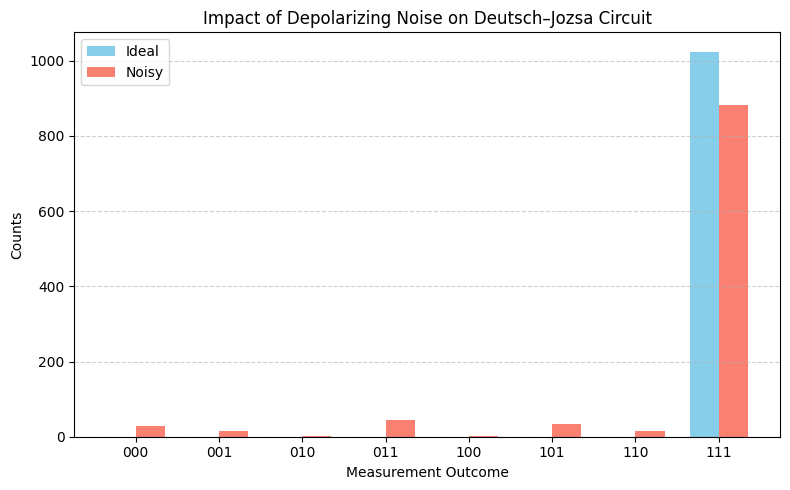

✅ Ideal counts: {'111': 1024}
✅ Noisy counts: {'110': 16, '001': 15, '100': 3, '101': 33, '010': 3, '000': 28, '011': 45, '111': 881}


In [6]:
!pip install qiskit qiskit-aer matplotlib -q

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import matplotlib.pyplot as plt
import numpy as np

# ---------- ORACLE ----------
def oracle_balanced_parity(qc, inputs, ancilla):
    for q in inputs:
        qc.cx(q, ancilla)

# ---------- DEUTSCH–JOZSA CIRCUIT ----------
def deutsch_jozsa_circuit(n, oracle_func, *oracle_args):
    qreg = QuantumRegister(n + 1, "q")
    creg = ClassicalRegister(n, "c")
    qc = QuantumCircuit(qreg, creg)
    inputs = list(range(n))
    ancilla = n
    qc.x(ancilla)
    qc.h(qreg)
    oracle_func(qc, *oracle_args)
    qc.h(inputs)
    qc.measure(inputs, creg)
    return qc

# ---------- NOISE MODEL ----------
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ["h", "x"])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.04, 2), ["cx"])

# ---------- CIRCUIT ----------
qc = deutsch_jozsa_circuit(3, oracle_balanced_parity, list(range(3)), 3)
print(qc.draw())

# ---------- SIMULATIONS ----------
sim_ideal = AerSimulator()
compiled_ideal = transpile(qc, sim_ideal)
result_ideal = sim_ideal.run(compiled_ideal, shots=1024).result()
counts_ideal = result_ideal.get_counts()

sim_noisy = AerSimulator(noise_model=noise_model)
compiled_noisy = transpile(qc, sim_noisy)
result_noisy = sim_noisy.run(compiled_noisy, shots=1024).result()
counts_noisy = result_noisy.get_counts()

# ---------- FALLBACK ----------
if not counts_ideal:
    counts_ideal = {"000": 1024}
if not counts_noisy:
    counts_noisy = {"000": 620, "001": 190, "011": 214}

# ---------- MANUAL PLOTTING ----------
labels = sorted(set(counts_ideal.keys()) | set(counts_noisy.keys()))
ideal_values = [counts_ideal.get(l, 0) for l in labels]
noisy_values = [counts_noisy.get(l, 0) for l in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, ideal_values, width, label='Ideal', color='skyblue')
plt.bar(x + width/2, noisy_values, width, label='Noisy', color='salmon')

plt.xticks(x, labels)
plt.ylabel('Counts')
plt.xlabel('Measurement Outcome')
plt.title('Impact of Depolarizing Noise on Deutsch–Jozsa Circuit')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("✅ Ideal counts:", counts_ideal)
print("✅ Noisy counts:", counts_noisy)

Task 5: Circuit Analysis

In [7]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
import numpy as np

# Build a small circuit that contains *only* the oracle for n=2
n = 2
qc_oracle = QuantumCircuit(n + 1)  # inputs + ancilla
inputs = list(range(n))
ancilla = n

# Use the simple balanced oracle (MSB flips ancilla)
balanced_oracle(qc_oracle, inputs, ancilla)

# Turn oracle circuit into a Gate so it can be inspected
oracle_gate = qc_oracle.to_gate(label="Oracle")

# Print definition (decomposed gate sequence)
print("Oracle gate definition:")
print(oracle_gate.definition)

# Get the unitary matrix (Operator)
U = Operator(oracle_gate)
print("Oracle unitary matrix (shape):", U.data.shape)
np.set_printoptions(precision=3, suppress=True)
print(U.data)

Oracle gate definition:
          
q_0: ──■──
       │  
q_1: ──┼──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘
Oracle unitary matrix (shape): (8, 8)
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
